In [479]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error



df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename", "start_time", "end_time", "edge", "meterID"])
df_clean.fillna(df_clean.median(), inplace=True)



In [480]:
target = "average_power_consumption"
X = df_clean.drop(columns=[target])
y = df_clean[target]
feature_names = df_clean.columns.tolist()


In [481]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# scaler_y = MinMaxScaler()
# y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
# y_scaled = (y - y.mean()) / y.std()
scaler_y = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()




In [482]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [483]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [484]:
class CNCCausalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.adjacency = nn.Parameter(torch.randn(input_dim, input_dim))  
        nn.init.xavier_uniform_(self.adjacency)  
        
        #Deeper network with more neurons
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),  
        )
        self.target_net = nn.Linear(64, 1)

    def forward(self, x):
        W = torch.tanh(self.adjacency)  
        masked_input = torch.matmul(x, W)
        shared = self.shared_net(masked_input)
        return self.target_net(shared)


In [485]:
model = CNCCausalModel(X_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  
criterion = nn.HuberLoss(delta=1.0)  

In [486]:
# X_tensor = torch.FloatTensor(X_scaled)
# y_tensor = torch.FloatTensor(y_scaled)

In [487]:
for epoch in range(3000):  
    optimizer.zero_grad()
    
    pred = model(X_train_tensor)
    loss = criterion(pred, y_train_tensor)
    
    
    W = torch.sigmoid(model.adjacency)
    h = torch.trace(torch.matrix_exp(W * W)) - W.shape[0]
    loss += 0.001 * h * h  
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.6f}, DAG Loss={h.item():.6f}")


Epoch 0: Loss=1.273309, DAG Loss=34.245010
Epoch 500: Loss=0.474622, DAG Loss=21.715630
Epoch 1000: Loss=0.409116, DAG Loss=20.159142
Epoch 1500: Loss=0.398946, DAG Loss=19.892738
Epoch 2000: Loss=0.396449, DAG Loss=19.837234
Epoch 2500: Loss=0.396388, DAG Loss=19.827614


In [488]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    adj_matrix = torch.sigmoid(model.adjacency).numpy()

y_pred_rescaled = scaler_y.inverse_transform(y_pred)


In [489]:
print("y mean:", y.mean(), "y std:", y.std())
print("y_scaled mean:", y_scaled.mean(), "y_scaled std:", y_scaled.std())


y mean: 2835.3724582008444 y std: 720.7970690058299
y_scaled mean: 0.457528488253665 y_scaled std: 0.2565619710294054


In [490]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred_rescaled)
print(f"R²: {r2:.3f}, MAE: {mae:.2f} kW")

R²: 0.869, MAE: 2790.75 kW


In [491]:
feature_names = [col for col in df_clean.columns if col != target]
print("Features:", feature_names)
print("Number of features:", len(feature_names))

Features: ['processing_time', 'missing_data', 'raw_volume', 'lines_of_code', 'tool_changes', 'travels_to_zero_point_in_rapid_traverse', 'axes_rotation', 'weighted_rotational_speed', 'weighted_tool_diameter', 'weighted_cutting_length', 'weighted_number_of_cutting_edges', 'weighted_cutting_speed', 'weighted_feed_per_tooth', 'weighted_feed_rate']
Number of features: 14


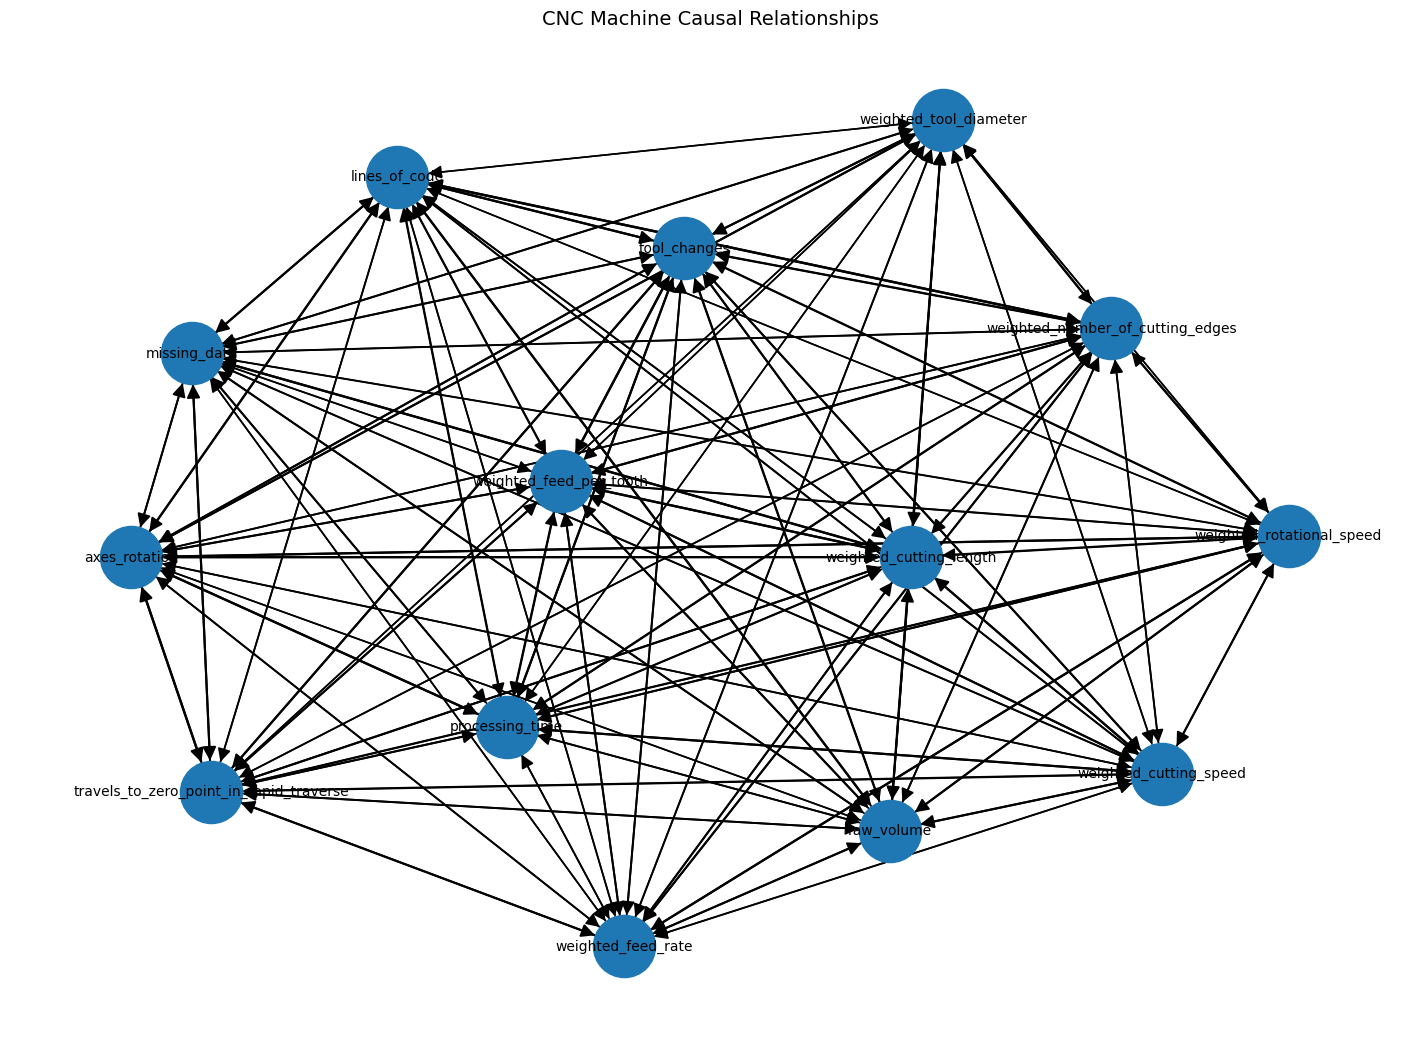

In [492]:
G = nx.DiGraph()
threshold = 0.2 

for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if adj_matrix[i, j] > threshold and i != j:
            G.add_edge(feature_names[i], feature_names[j], weight=adj_matrix[i, j])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.7)
nx.draw(G, pos, with_labels=True, 
        node_size=2000,
        width=[G[u][v]['weight']*3 for u, v in G.edges],
        arrowsize=20,
        font_size=10)
plt.title("CNC Machine Causal Relationships", fontsize=14)
plt.show()

In [493]:
feature_importance = adj_matrix.mean(axis=1)  
results = pd.DataFrame({
    'Feature': feature_names,
    'Causal_Weight': feature_importance
}).sort_values('Causal_Weight', key=abs, ascending=False)

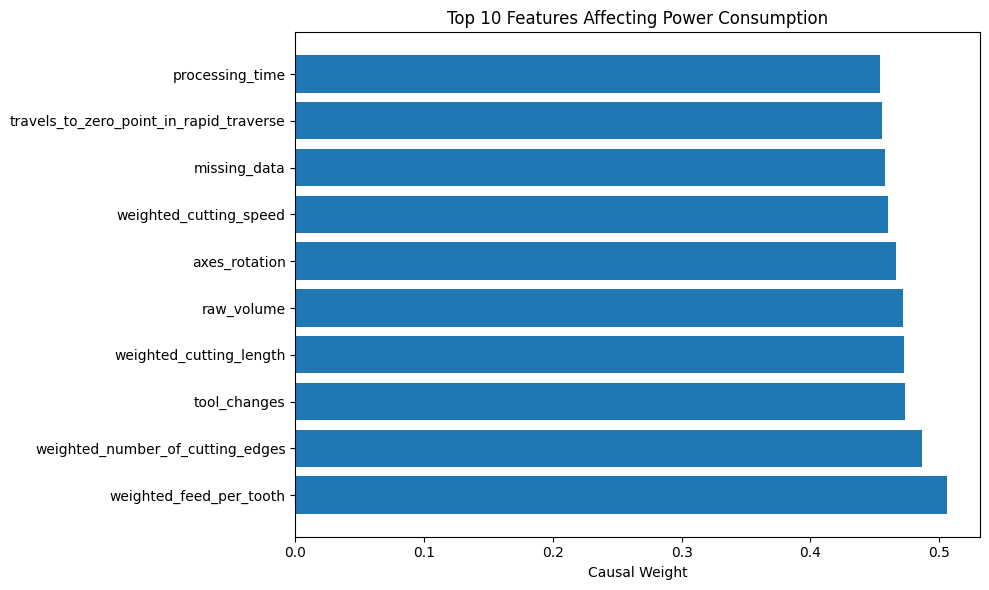

In [494]:
plt.figure(figsize=(10, 6))
plt.barh(results['Feature'].head(10), results['Causal_Weight'].head(10))
plt.xlabel('Causal Weight')
plt.title('Top 10 Features Affecting Power Consumption')
plt.tight_layout()
plt.show()